# Time Series Testing

Looking into the following models: 
1. Time GPT
2. sktime Prophet
3. sktime BATS
4. sktime TBATS

## 1. Time GPT

Requested a token from https://docs.nixtla.io to access the `TimeGPT` API.

In [ ]:
#! pip install nixtlats

In [ ]:
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(token=)
# Check if the token provided is valid.
if timegpt.validate_token():
    print("Token validation successful!")  # Token is valid.
else:
    # Raise an exception if token validation fails.
    raise Exception("Token validation failed! Please check go to https://dashboard.nixtla.io/ to get your token.")

In [ ]:
# Loading the air passengers dataset from a remote URL as an example
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
# Forecasting the next 12 horizons using TimeGPT
timegpt_fcst_df = timegpt.forecast(df=df, h=12, time_col='timestamp', target_col='value')

# Plotting the original data combined with the forecasted data.
pd.concat([df, timegpt_fcst_df]).set_index('timestamp').plot()

**Got a 429 response error after running the above cell for the first time - maxed out requests after 2 total requests so could not test out further**

TimeGPT is still in Beta and has less then 1000 people using it currently. Will continue to look back and see if request #'s increase

# sktime testing

pip install the required packages if this is the first time using any of these. prophet and tbats are needed even for the sktime versions of the below models

In [1]:
#! pip install sktime
#! pip install prophet
#! pip install tbats

## Import Required Packages

In [2]:
import pandas as pd
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.datasets import load_airline
from sktime.forecasting.tbats import TBATS


import statsmodels.api as sm
from sktime.performance_metrics.forecasting import mean_squared_error
import numpy as np

## Air Passenger Data

For this first analysis, will use the air passenger dataset

sktime has a function called `plot_series` which allows a quick plot of the time series being analyzed

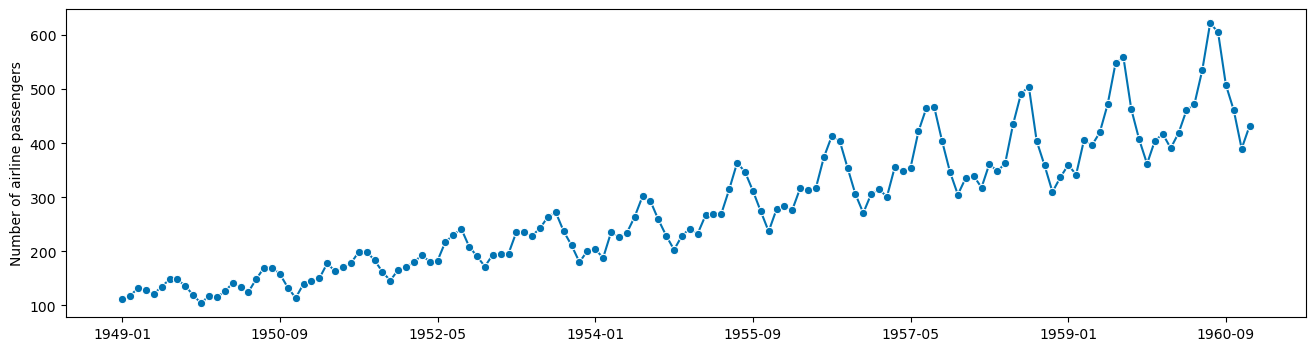

In [3]:
y = load_airline()
fig, ax = plot_series(y) 

In [4]:
display(y)

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

sktime also has a function called `plot_correlations`, which quickly displays the series, ACF plot and PACF plot. 

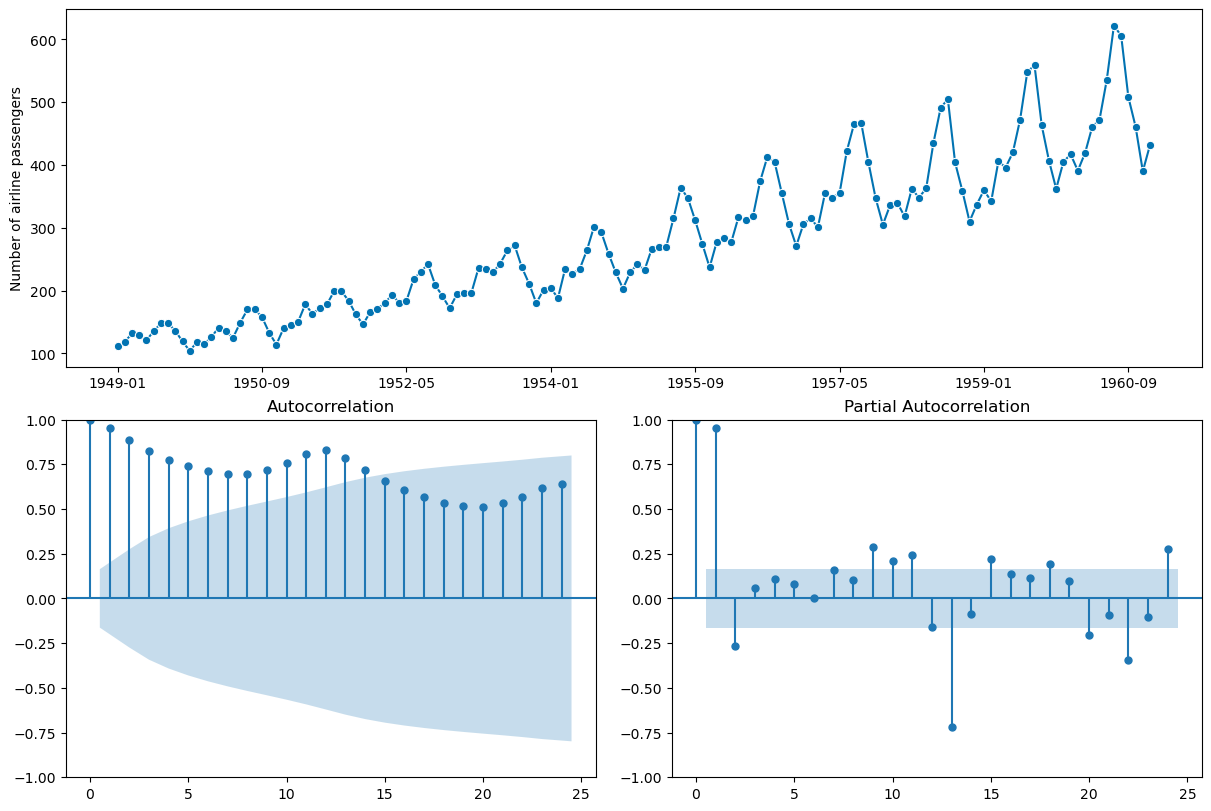

In [5]:
fig, ax = plot_correlations(y)

## Naive Model

In [6]:
# step 1: data specification
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=0.2)

# step 2: specifying forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y_train)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

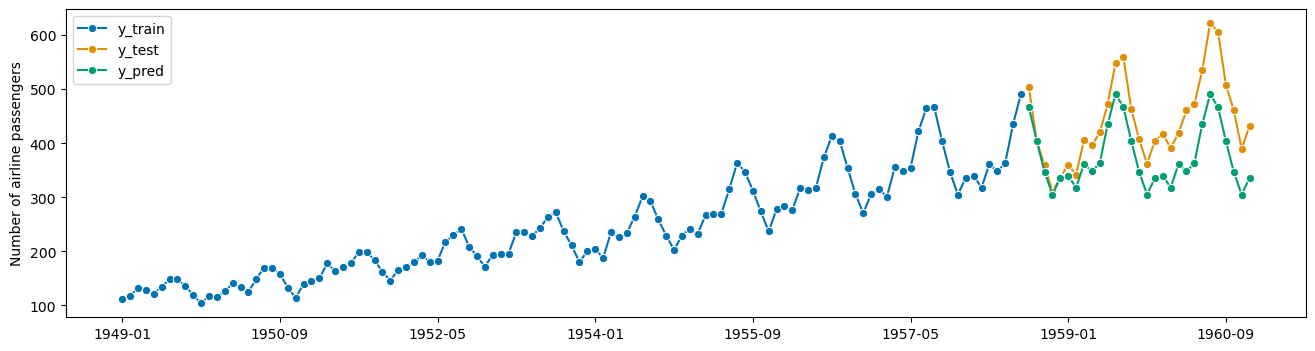

In [7]:
plot_series(y_train, y_test, y_pred, labels=["y_train","y_test", "y_pred"])

In [8]:
stats = {'Model': 'NaiveForecaster',
         'MSE' : mean_squared_error(y_test, y_pred),
         'RMSE':np.sqrt(mean_squared_error(y_test, y_pred)),
         'MAPE': mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

        }
stats_df = pd.DataFrame([stats])
stats_df

,Model,MSE,RMSE,MAPE
0,NaiveForecaster,5660.137931,75.233888,0.140379


## 2. Prophet

Prophet is a forecasting model created by Facebook and is now open-source in both Python and R. This model is based on an **additive model**, meaning non-linear trends are fit with yearly, weekly, and daily seasonality, plus holidays. 

Below, the air passenger dataset will be forecasted using the prophet model from `sktime`. 

In [9]:
y = y.to_timestamp(freq='M')
# split data into training and test sets
y_train, y_test = temporal_train_test_split(y, test_size=0.2)
y_train

Period
1949-01-31    112.0
1949-02-28    118.0
1949-03-31    132.0
1949-04-30    129.0
1949-05-31    121.0
              ...  
1958-03-31    362.0
1958-04-30    348.0
1958-05-31    363.0
1958-06-30    435.0
1958-07-31    491.0
Freq: M, Name: Number of airline passengers, Length: 115, dtype: float64

From sktime documentation - "Prophet forecaster by wrapping Facebook's prophet algorithm"

Allows direct interface to facebook prophet using the sktime interface


Prophet Hyperparameters:
- freq: datetimeindex frequency
- add_seasonality: dict with args for prophet.add_seasonality
- add_country_holidays: dict; can have country_name
- growth: str linear or log to specify the trend
- growth_floor: growth saturation min; only used if growth is log
- growth_cap: growth saturation max
- changepoints: list of dates to include potential changepoints. if not selected, potential changepoints are selected automatically
- n_changepoints: num of potential changepoints to include
- changepoint_range: prop of history in which trend changepoints will be est. 
- yearly_seasonality: fit yearly seasonality 
- weekly_seasonality: fit weekly seasonality
- daily_seasonality: fit daily seasonality 
- holidays: pd.DataFrame with columns holiday and ds
- seasonality_mode: either 'additive' or 'multiplicative'
- seasonality_prior_scale: param modulating the strength of the seasonality model
- holidays_prior_scale: param modulating the strength of the holiday components model
- changepoint_prior_scale: param modulating the flexibility of the auto changepoint selection
- mcmc_samples: int value, if greater than 0 will do Bayesian inference
- alpha: width of uncertainty intervals provided for the forecast
- uncertainty_samples: num of simulated draws used to est
- stan_backend
- verbose

15:01:46 - cmdstanpy - INFO - Chain [1] start processing
15:01:46 - cmdstanpy - INFO - Chain [1] done processing


(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

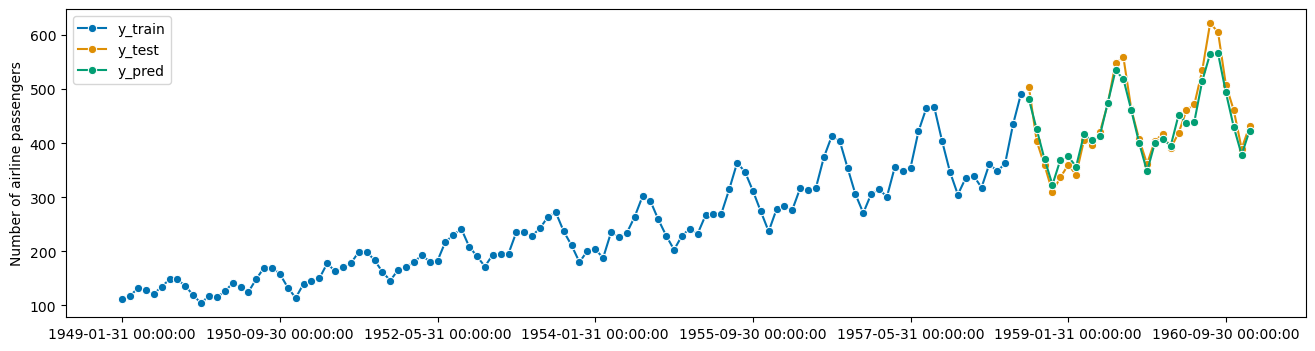

In [10]:
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={'country_name': 'USA'},
    yearly_seasonality=True)

forecaster.fit(y_train)  

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [11]:
stats = {'Model': 'sktime Prophet',
         'MSE' : mean_squared_error(y_test, y_pred),
         'RMSE':np.sqrt(mean_squared_error(y_test, y_pred)),
         'MAPE': mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
        }

stats_df = pd.concat([stats_df, pd.DataFrame([stats])], axis=0).reset_index(drop=True)
stats_df

,Model,MSE,RMSE,MAPE
0,NaiveForecaster,5660.137931,75.233888,0.140379
1,sktime Prophet,494.009229,22.226318,0.039818


**What is the difference between sktime prophet and just the normal prophet module?**

In [12]:
air_df = pd.DataFrame(y)
air_df.reset_index(inplace=True)
air_df.rename(columns={'Period': 'ds', 'Number of airline passengers': 'y'}, inplace=True)
air_df

,ds,y
0,1949-01-31,112.0
1,1949-02-28,118.0
2,1949-03-31,132.0
3,1949-04-30,129.0
4,1949-05-31,121.0
...,...,...
139,1960-08-31,606.0
140,1960-09-30,508.0
141,1960-10-31,461.0
142,1960-11-30,390.0


15:01:47 - cmdstanpy - INFO - Chain [1] start processing
15:01:47 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
504,1961-12-27,499.894435,470.604000,529.202936
505,1961-12-28,497.814629,469.160891,524.894381
506,1961-12-29,495.187949,467.843282,525.046511
507,1961-12-30,492.074171,464.133338,520.150483
508,1961-12-31,488.545444,459.769230,516.246050


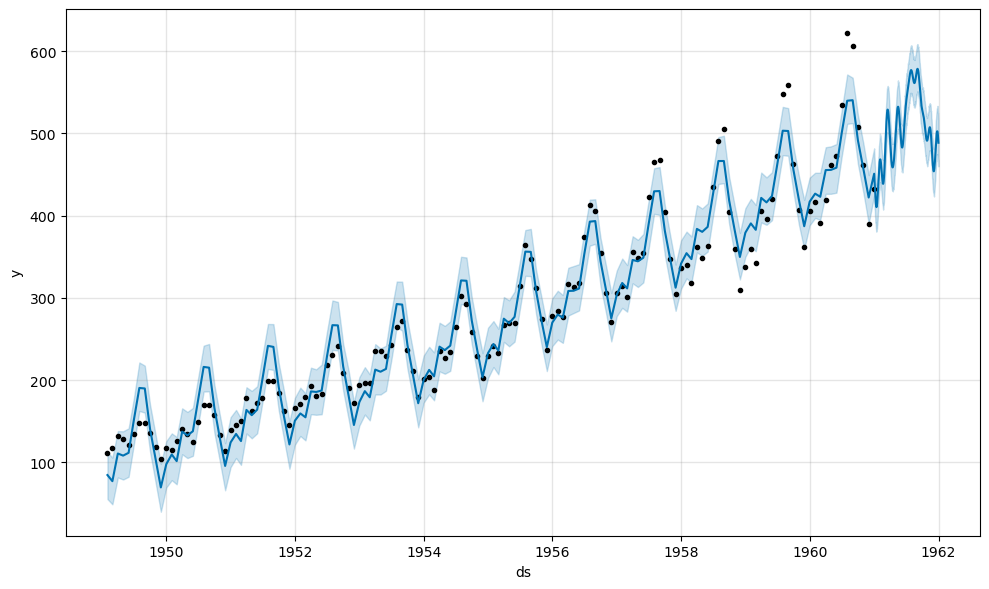

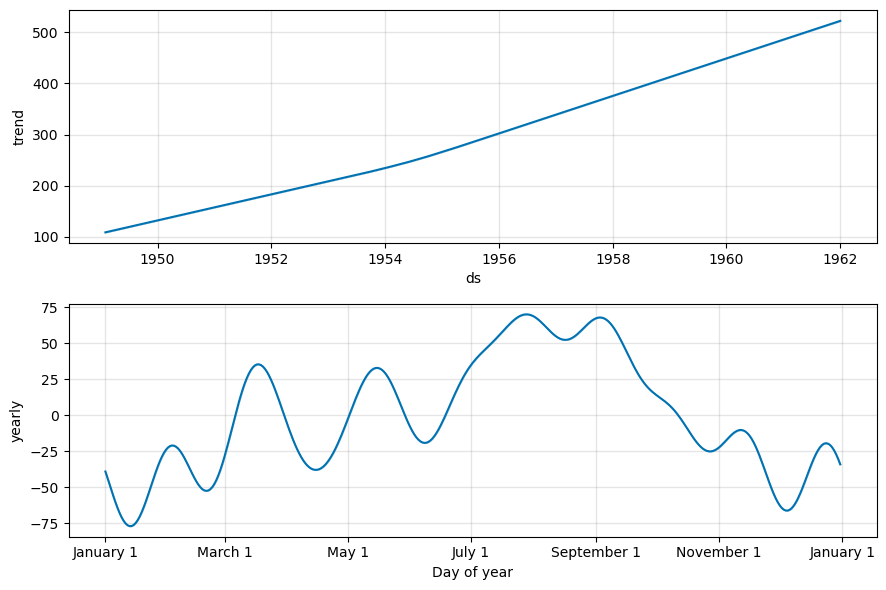

In [13]:
# Python
from prophet import Prophet
m = Prophet()
m.fit(air_df)

future = m.make_future_dataframe(365)
future.tail()

forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

## 3. BATS
- Box-Cox transformation
- ARMA errors
- trend
- seasonal compontents

From sktime also, this is a forecaster for time series with multiple seasonality

In [14]:
from sktime.forecasting.bats import BATS

In [15]:
forecaster = BATS(  
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=True,
    sp=12,
    use_arma_errors=False,
    n_jobs=1)

forecaster.fit(y_train)  

/Users/katiesnedeker/opt/anaconda3/lib/python3.9/site-packages/tbats/error/ExceptionHandler.py:13: InputArgsWarning: When use_damped_trend can be used only with use_trend. Setting damped trend to False.
  warnings.warn(message, warning_type)


BATS(n_jobs=1, sp=12, use_arma_errors=False, use_box_cox=False,
     use_damped_trend=True, use_trend=False)

In [16]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

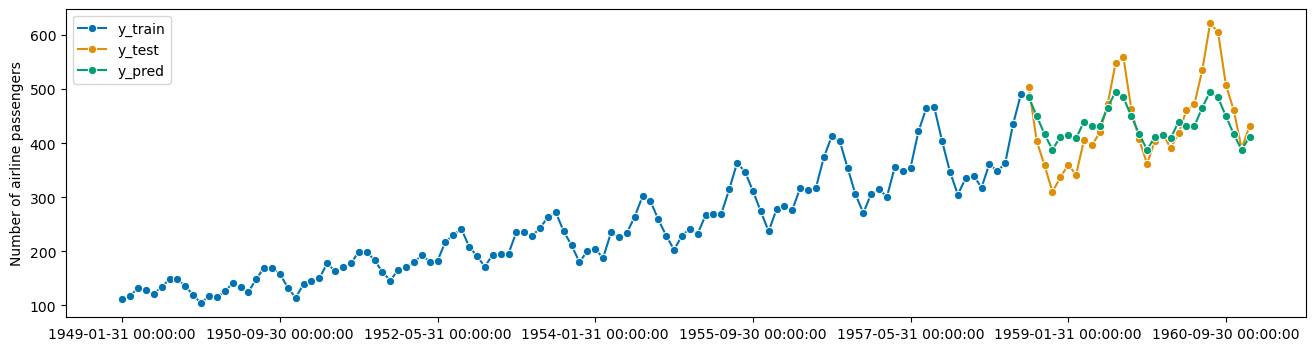

In [17]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [18]:
stats = {'Model': 'BATS',
         'MSE' : mean_squared_error(y_test, y_pred),
         'RMSE':np.sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
        }

stats_df = pd.concat([stats_df, pd.DataFrame([stats])], axis=0).reset_index(drop=True)
stats_df

,Model,MSE,RMSE,MAPE
0,NaiveForecaster,5660.137931,75.233888,0.140379
1,sktime Prophet,494.009229,22.226318,0.039818
2,BATS,2807.845739,52.989110,0.095433


## TBATS

- Trigonometric seasonality
- Box-Cox transformation
- ARMA errors
- Trend
- Seasonal Components

Designed for data with multiple seasonal periods

In [19]:
forecaster = TBATS(  
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=False,
    sp=12,
    use_arma_errors=False,
    n_jobs=1)

forecaster.fit(y_train)  
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

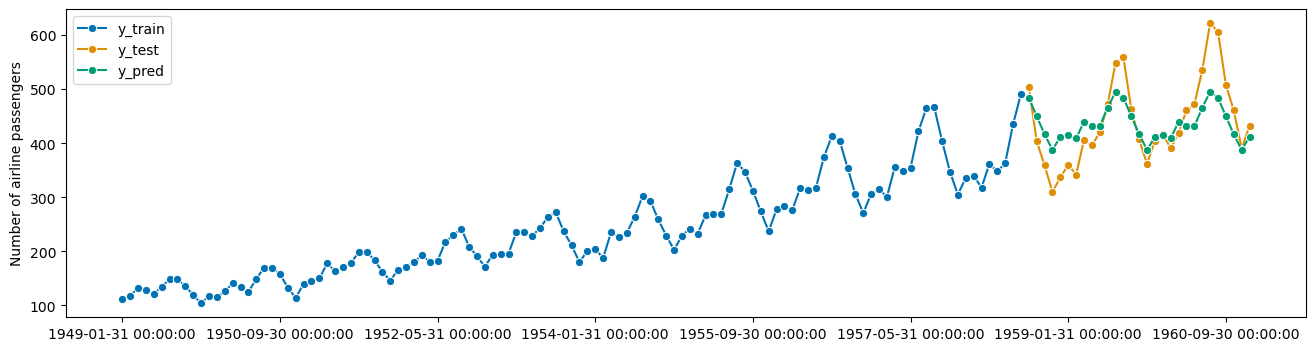

In [20]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [21]:
stats = {'Model': 'TBATS',
         'MSE' : mean_squared_error(y_test, y_pred),
         'RMSE':np.sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
        }

stats_df = pd.concat([stats_df, pd.DataFrame([stats])], axis=0).reset_index(drop=True)
stats_df

,Model,MSE,RMSE,MAPE
0,NaiveForecaster,5660.137931,75.233888,0.140379
1,sktime Prophet,494.009229,22.226318,0.039818
2,BATS,2807.845739,52.989110,0.095433
3,TBATS,2813.480216,53.042249,0.095412


----------

## Test prophet on other data

Data: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Found Daily Climate Time Series data from Kaggle

In [22]:
climate_test = pd.read_csv("archive/DailyDelhiClimateTest.csv", index_col=0)
climate_train = pd.read_csv("archive/DailyDelhiClimateTrain.csv",index_col=0)
climate_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [23]:
climate_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB


In [24]:
climate_train.index = pd.to_datetime(climate_train.index)
climate_test.index = pd.to_datetime(climate_test.index)
climate_train

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [25]:
y_train = climate_train.iloc[:,0]
y_test = climate_test.iloc[:,0]
y_train

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='meantemp'>)

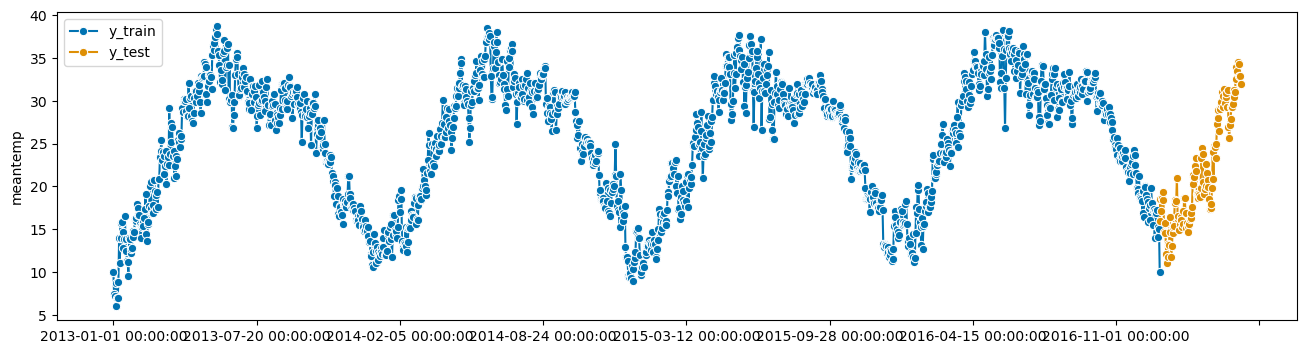

In [26]:
plot_series(y_train, y_test, labels=['y_train','y_test'])

In [53]:
y_train2 = y_train[0:7]
y_train2

2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
2013-01-06     7.000000
2013-01-07     7.000000
Name: meantemp, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='meantemp'>)

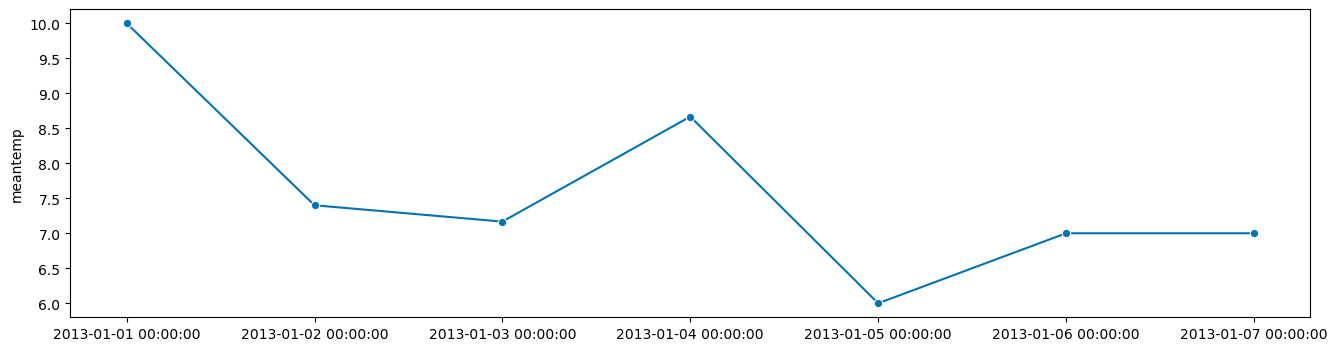

In [54]:
plot_series(y_train2)

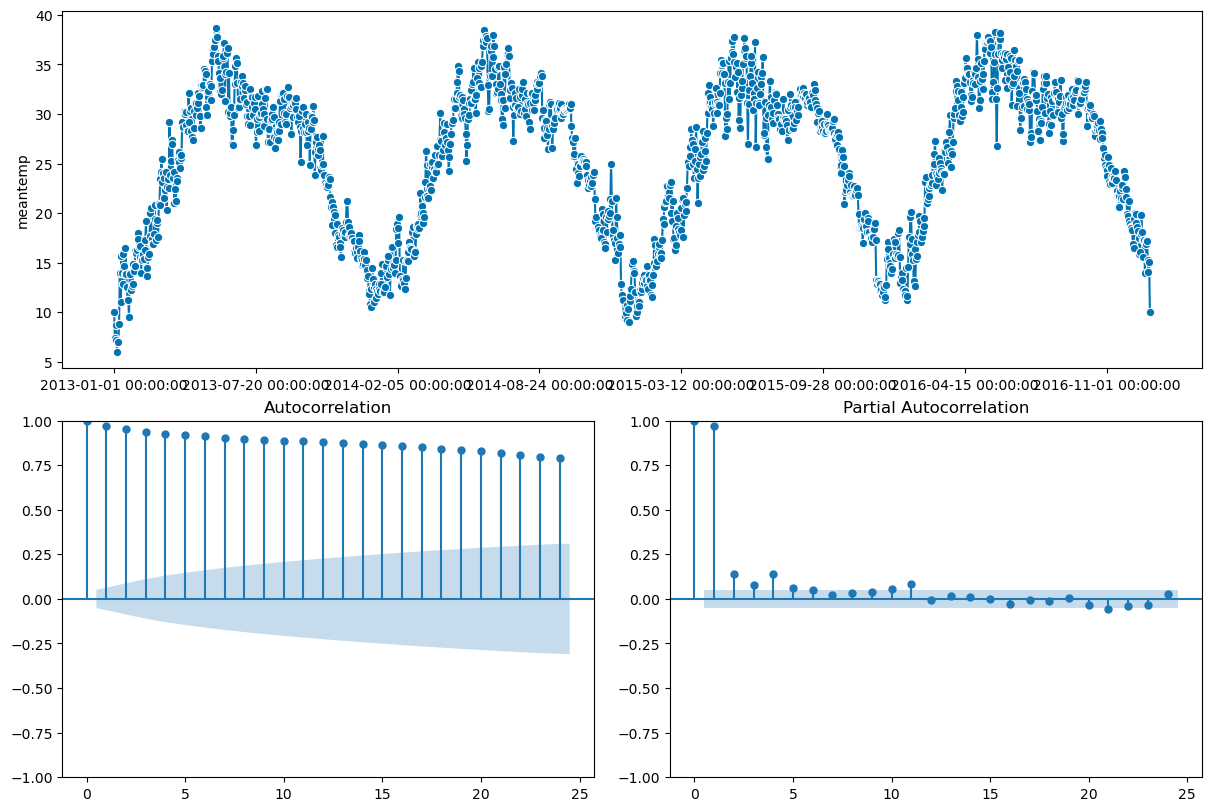

In [27]:
fig,ax = plot_correlations(y_train)

In [28]:
# fh = ForecastingHorizon(y_test.index, is_relative=False)

# forecaster = NaiveForecaster(strategy="last", sp=12)

# forecaster.fit(y_train)

# y_pred = forecaster.predict(fh)

In [29]:
# Prophet model
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(  
    seasonality_mode='additive',
    #n_changepoints=int(len(y_train) / 12),
    add_country_holidays={'country_name': 'USA'},
    daily_seasonality=True,
    
)
forecaster.fit(y_train)  

15:01:49 - cmdstanpy - INFO - Chain [1] start processing
15:01:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'USA'}, daily_seasonality=True)

In [30]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='meantemp'>)

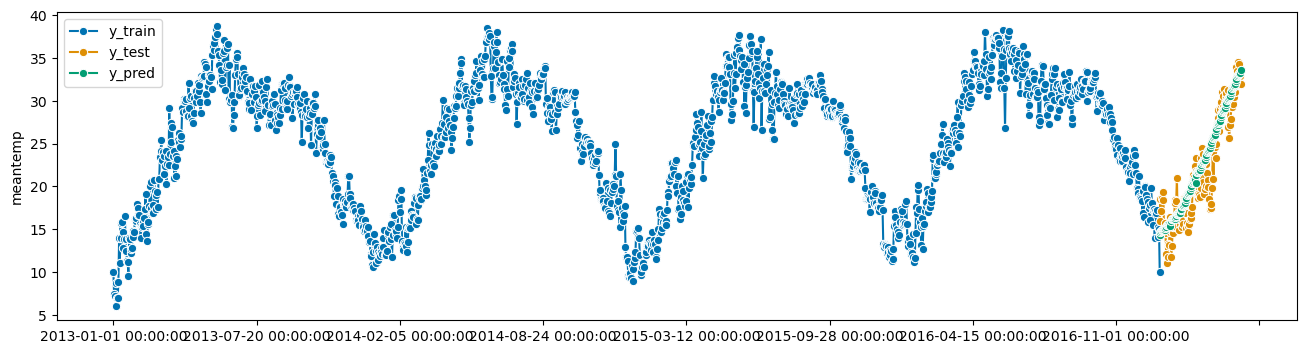

In [31]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [32]:
stats = {'Model': 'sktime prophet',
         'MSE' : mean_squared_error(y_test, y_pred),
         'RMSE':np.sqrt(mean_squared_error(y_test, y_pred)),
         'MAPE': mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

        }
stats_df = pd.DataFrame([stats])
stats_df

,Model,MSE,RMSE,MAPE
0,sktime prophet,7.372396,2.715216,0.118491


In [33]:
climate_train.reset_index(inplace=True)
climate_train.rename(columns={'index': 'ds', 'meantemp':'y'}, inplace=True)

climate_test.reset_index(inplace=True)
climate_test.rename(columns={'index': 'ds', 'meantemp':'y'}, inplace=True)

In [34]:
climate_train

,ds,y,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


15:01:50 - cmdstanpy - INFO - Chain [1] start processing
15:01:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1571,2017-04-21,33.037166,30.449332,35.464568
1572,2017-04-22,33.118770,30.421948,35.659783
1573,2017-04-23,33.165329,30.596780,35.874463
1574,2017-04-24,33.515783,30.918735,36.137686
1575,2017-04-25,33.720147,31.206876,36.288533


(1576, 19)


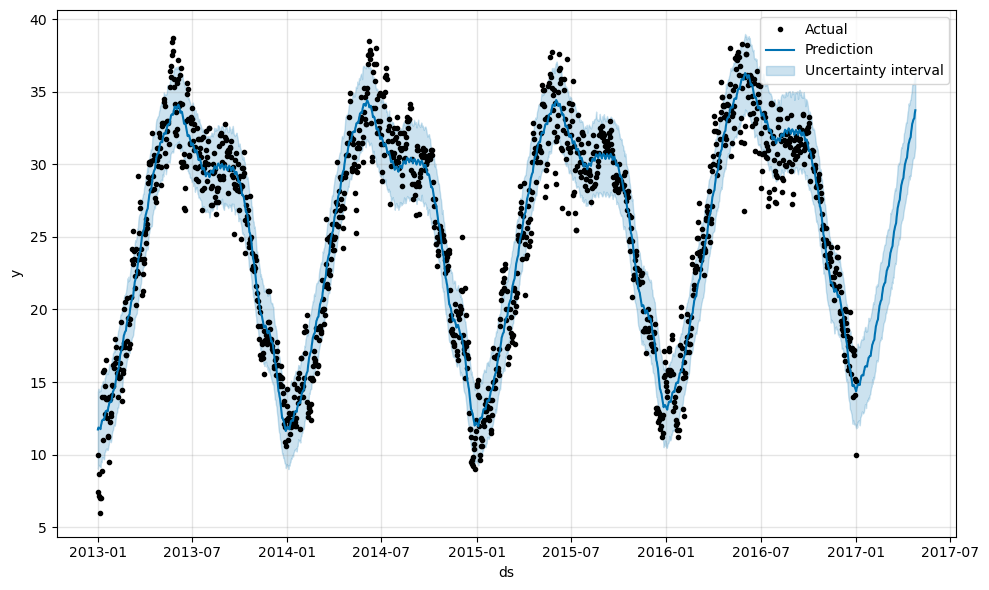

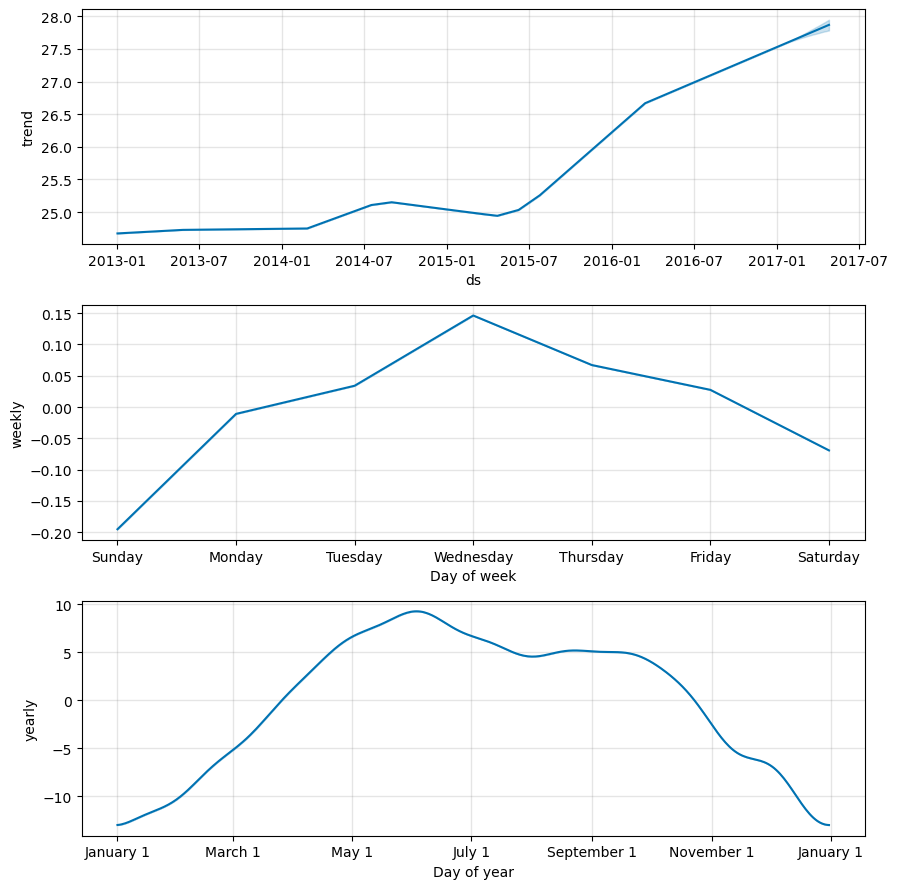

In [35]:
# Python
from prophet import Prophet
m = Prophet()
m.fit(climate_train)

future = m.make_future_dataframe(periods=114)
future.tail()

forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
print(forecast.shape)

fig1 = m.plot(forecast)
plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])


fig2 = m.plot_components(forecast)

In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,24.672730,9.032932,14.328032,24.672730,24.672730,-12.936730,-12.936730,-12.936730,0.034091,0.034091,0.034091,-12.970821,-12.970821,-12.970821,0.0,0.0,0.0,11.736001
1,2013-01-02,24.673116,9.311298,14.549263,24.673116,24.673116,-12.800960,-12.800960,-12.800960,0.146298,0.146298,0.146298,-12.947258,-12.947258,-12.947258,0.0,0.0,0.0,11.872156
2,2013-01-03,24.673501,9.225873,14.317582,24.673501,24.673501,-12.841288,-12.841288,-12.841288,0.067171,0.067171,0.067171,-12.908460,-12.908460,-12.908460,0.0,0.0,0.0,11.832213
3,2013-01-04,24.673887,9.239469,14.463091,24.673887,24.673887,-12.828845,-12.828845,-12.828845,0.027529,0.027529,0.027529,-12.856374,-12.856374,-12.856374,0.0,0.0,0.0,11.845041
4,2013-01-05,24.674272,9.204297,14.379711,24.674272,24.674272,-12.862138,-12.862138,-12.862138,-0.069144,-0.069144,-0.069144,-12.792994,-12.792994,-12.792994,0.0,0.0,0.0,11.812134


In [37]:
predictions = forecast.iloc[-len(climate_test):]['yhat']
predictions

1462    14.576559
1463    14.663244
1464    14.830486
1465    14.817690
1466    14.853683
          ...    
1571    33.037166
1572    33.118770
1573    33.165329
1574    33.515783
1575    33.720147
Name: yhat, Length: 114, dtype: float64

In [38]:
actuals = climate_test['y']

In [39]:
stats = {'Model': 'Prophet',
         'MSE' : mean_squared_error(actuals, predictions),
         'RMSE':np.sqrt(mean_squared_error(actuals, predictions)),
         'MAPE': mean_absolute_percentage_error(actuals, predictions, symmetric=False)

        }
stats_df = pd.concat([stats_df, pd.DataFrame([stats])], axis=0).reset_index(drop=True)

stats_df

,Model,MSE,RMSE,MAPE
0,sktime prophet,7.372396,2.715216,0.118491
1,Prophet,7.569314,2.751239,0.119075


In [40]:
forecaster = BATS(  
    use_box_cox=True,
    use_trend=False,
    use_damped_trend=False,
    use_arma_errors=False,
    n_jobs=1, 
    sp=12)

forecaster.fit(y_train)  

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='meantemp'>)

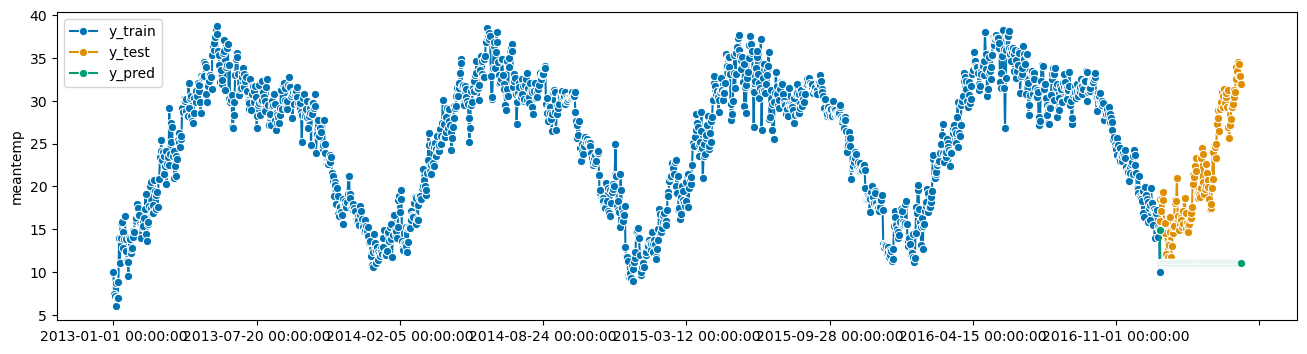

In [41]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], )

In [42]:
y_pred

2017-01-01    14.916840
2017-01-02    11.039824
2017-01-03    11.039824
2017-01-04    11.039824
2017-01-05    11.039824
                ...    
2017-04-20    11.039824
2017-04-21    11.039824
2017-04-22    11.039824
2017-04-23    11.039824
2017-04-24    11.039824
Name: meantemp, Length: 114, dtype: float64

In [43]:
y_test

2017-01-01    15.913043
2017-01-02    18.500000
2017-01-03    17.111111
2017-01-04    18.700000
2017-01-05    18.388889
                ...    
2017-04-20    34.500000
2017-04-21    34.250000
2017-04-22    32.900000
2017-04-23    32.875000
2017-04-24    32.000000
Name: meantemp, Length: 114, dtype: float64

In [44]:
stats = {'Model': 'BATS',
         'MSE' : mean_squared_error(y_test, y_pred),
         'RMSE':np.sqrt(mean_squared_error(y_test, y_pred)),
          'MAPE': mean_absolute_percentage_error(y_test, y_pred, symmetric=False)}

stats_df = pd.concat([stats_df, pd.DataFrame([stats])], axis=0).reset_index(drop=True)
stats_df

,Model,MSE,RMSE,MAPE
0,sktime prophet,7.372396,2.715216,0.118491
1,Prophet,7.569314,2.751239,0.119075
2,BATS,153.814438,12.402195,0.444987
